## Implementation of LSTM(Long short-term memory) based VAE(variational Autoencoder)
1. All the necessary libraries are imported
2. Data are loaded and scaled
3. Data is preprocessed (first the data is truncated according to time_step( here 50), and divide into possible samples), and then split into train and test data
4. Model architechture is defined and trained on train data
5. Model is saved
6. For Inference, tests are made on the model, and the comparison between orginal test video and generated video are stored (in output/inference folder)

## Import Dependency

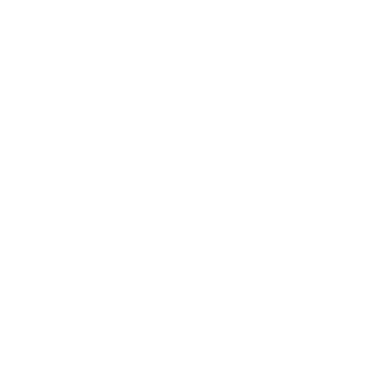

In [4]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.nn.modules.conv import ConvTranspose1d
from torch.nn import Module, Conv1d, Sequential, Dropout, MaxPool1d
import matplotlib.pyplot as plt
from visualize import visualize,animate
from torchvision import models
from torchsummary import summary

## Load Data

In [7]:
res = np.load("data\mariel_beyond.npy")
motion_data=np.array(res)
arr_reshaped = motion_data.reshape(-1, 1)
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(arr_reshaped)
scaled_data = scaled_data.reshape(motion_data.shape)
scaled_data.shape

(55, 6803, 3)

In [2]:
"""res = np.load("data\mariel_beyond.npy")
scaled_data=np.array(res)"""

## Pre-processing

In [8]:
scaled_data=scaled_data.transpose(1, 0, 2).reshape(6803, -1)
scaled_data.shape #55 * 3 = 165

(6803, 165)

In [9]:
time_steps = 50
num_features = scaled_data.shape[1]

# Reshape data into smaller sequences
num_sequences = scaled_data.shape[0] // time_steps
scaled_data = scaled_data[:num_sequences*time_steps]  # truncate data to a size divisible by time_steps (whole sequence time step, [x,y,z] coordinates of joints)

In [10]:
scaled_data.shape

(6800, 165)

In [11]:
data = scaled_data.reshape((num_sequences, time_steps, num_features))  #(no. of sample, time_step, [x,y,z] coordinates of joints)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [12]:
train_data.shape

(108, 50, 165)

In [15]:
#preparation of training data

train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
input_size=train_data_tensor.shape[-1]
num_samples=train_data.shape[0] 
batch_size = 32
train_loader = DataLoader(TensorDataset(train_data_tensor), batch_size=batch_size, shuffle=True)

## Training

In [16]:
class LSTMVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers=1):
        super(LSTMVAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_logvar = nn.Linear(hidden_size, latent_size)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(latent_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_size, input_size)
        
        # Post-processing parameters
        self.filter = nn.Conv1d(input_size, input_size, kernel_size=3, padding=1)  # filter for smoothing
        
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        mean = self.encoder_mean(h_n[-1])  # Using the output of the last LSTM layer
        logvar = self.encoder_logvar(h_n[-1])  # Using the output of the last LSTM layer
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z, seq_len):
        z = z.unsqueeze(1).repeat(1, seq_len, 1)
        output, _ = self.decoder_lstm(z)
        decoded = self.decoder_output(output)
        return decoded
    
    def post_process(self, decoded):
        decoded = decoded.permute(0, 2, 1)  # Change shape for Conv1d input
        decoded_smooth = self.filter(decoded)
        decoded_smooth = decoded_smooth.permute(0, 2, 1)  # Restore original shape
        return decoded_smooth
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decode(z, x.size(1))
        decoded_smooth = self.post_process(decoded)
        return decoded_smooth, mean, logvar

def loss_function(decoded, x, mean, logvar):
    recon_loss = nn.functional.mse_loss(decoded, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_divergence, kl_divergence


In [17]:
hidden_size = 128
latent_size = 64
num_layers = 2
vae = LSTMVAE(input_size, hidden_size, latent_size, num_layers)

In [18]:

optimizer = optim.Adam(vae.parameters(), lr= 0.001)

#optimizer=optim.SGD(vae.parameters(), lr=0.1, momentum=0.9)
losses = []
epochs = 10000
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch[0]
        decoded, mean, logvar = vae(x)
        loss, kl = loss_function(decoded, x, mean, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss = total_loss / num_samples
    losses.append(avg_loss)  # Store the loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {avg_loss}, kl: {kl/num_samples}")
    

Epoch 1, Loss: 2741.941948784722, kl: 0.06901600956916809
Epoch 2, Loss: 1314.5641276041667, kl: 0.7214106917381287
Epoch 3, Loss: 352.32573671694155, kl: 0.7872466444969177
Epoch 4, Loss: 174.76664790400753, kl: 0.5213584303855896
Epoch 5, Loss: 141.41765679253473, kl: 0.48641473054885864
Epoch 6, Loss: 151.0654489022714, kl: 0.4550502896308899
Epoch 7, Loss: 112.54782669632523, kl: 0.39759764075279236
Epoch 8, Loss: 106.73871301721644, kl: 0.3564729392528534
Epoch 9, Loss: 95.65581371166088, kl: 0.33666738867759705
Epoch 10, Loss: 97.06419089988425, kl: 0.31502941250801086
Epoch 11, Loss: 93.64933946397569, kl: 0.2925121486186981
Epoch 12, Loss: 91.08946736653645, kl: 0.270122230052948
Epoch 13, Loss: 90.07183837890625, kl: 0.25265058875083923
Epoch 14, Loss: 87.98690852412471, kl: 0.23894447088241577
Epoch 15, Loss: 86.49114481608073, kl: 0.22343333065509796
Epoch 16, Loss: 86.76693386501736, kl: 0.2083364874124527
Epoch 17, Loss: 86.76928484881365, kl: 0.19654817879199982
Epoch 18,

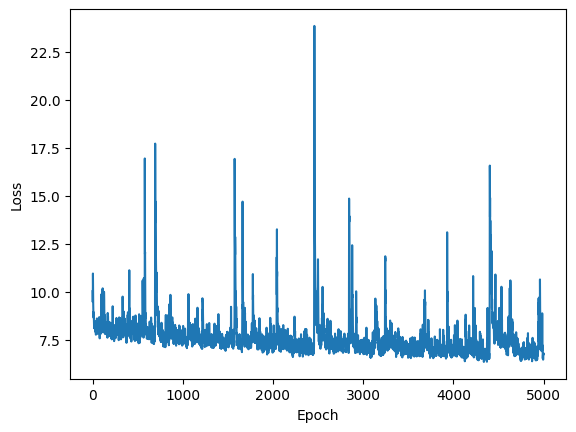

In [28]:
plt.plot(losses[5000:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
print(vae)

LSTMVAE(
  (encoder_lstm): LSTM(165, 128, num_layers=2, batch_first=True)
  (encoder_mean): Linear(in_features=128, out_features=64, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder_lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=165, bias=True)
  (filter): Conv1d(165, 165, kernel_size=(3,), stride=(1,), padding=(1,))
)


In [30]:
for param_tensor in vae.state_dict():
    print(param_tensor, "\t\t", vae.state_dict()[param_tensor].size())

encoder_lstm.weight_ih_l0 		 torch.Size([512, 165])
encoder_lstm.weight_hh_l0 		 torch.Size([512, 128])
encoder_lstm.bias_ih_l0 		 torch.Size([512])
encoder_lstm.bias_hh_l0 		 torch.Size([512])
encoder_lstm.weight_ih_l1 		 torch.Size([512, 128])
encoder_lstm.weight_hh_l1 		 torch.Size([512, 128])
encoder_lstm.bias_ih_l1 		 torch.Size([512])
encoder_lstm.bias_hh_l1 		 torch.Size([512])
encoder_mean.weight 		 torch.Size([64, 128])
encoder_mean.bias 		 torch.Size([64])
encoder_logvar.weight 		 torch.Size([64, 128])
encoder_logvar.bias 		 torch.Size([64])
decoder_lstm.weight_ih_l0 		 torch.Size([512, 64])
decoder_lstm.weight_hh_l0 		 torch.Size([512, 128])
decoder_lstm.bias_ih_l0 		 torch.Size([512])
decoder_lstm.bias_hh_l0 		 torch.Size([512])
decoder_lstm.weight_ih_l1 		 torch.Size([512, 128])
decoder_lstm.weight_hh_l1 		 torch.Size([512, 128])
decoder_lstm.bias_ih_l1 		 torch.Size([512])
decoder_lstm.bias_hh_l1 		 torch.Size([512])
decoder_output.weight 		 torch.Size([165, 128])
decoder

In [31]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [32]:
count_parameters(vae)

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
| encoder_lstm.weight_ih_l0 |   84480    |
| encoder_lstm.weight_hh_l0 |   65536    |
|  encoder_lstm.bias_ih_l0  |    512     |
|  encoder_lstm.bias_hh_l0  |    512     |
| encoder_lstm.weight_ih_l1 |   65536    |
| encoder_lstm.weight_hh_l1 |   65536    |
|  encoder_lstm.bias_ih_l1  |    512     |
|  encoder_lstm.bias_hh_l1  |    512     |
|    encoder_mean.weight    |    8192    |
|     encoder_mean.bias     |     64     |
|   encoder_logvar.weight   |    8192    |
|    encoder_logvar.bias    |     64     |
| decoder_lstm.weight_ih_l0 |   32768    |
| decoder_lstm.weight_hh_l0 |   65536    |
|  decoder_lstm.bias_ih_l0  |    512     |
|  decoder_lstm.bias_hh_l0  |    512     |
| decoder_lstm.weight_ih_l1 |   65536    |
| decoder_lstm.weight_hh_l1 |   65536    |
|  decoder_lstm.bias_ih_l1  |    512     |
|  decoder_lstm.bias_hh_l1  |    512     |
|   decoder

634197

## Saving the model

In [53]:
torch.save(vae, "model\LSTMVAE.pt")

## Inference and Testing

In [55]:
vae = LSTMVAE(input_size, hidden_size, latent_size, num_layers)
vae.load_state_dict(torch.load("model\LSTMVAE.pt"))

<All keys matched successfully>

In [57]:
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

# Pass the test data through the trained VAE model
vae.eval()
with torch.no_grad():
    decoded, _, _ = vae(test_data_tensor)

torch.Size([28, 64])


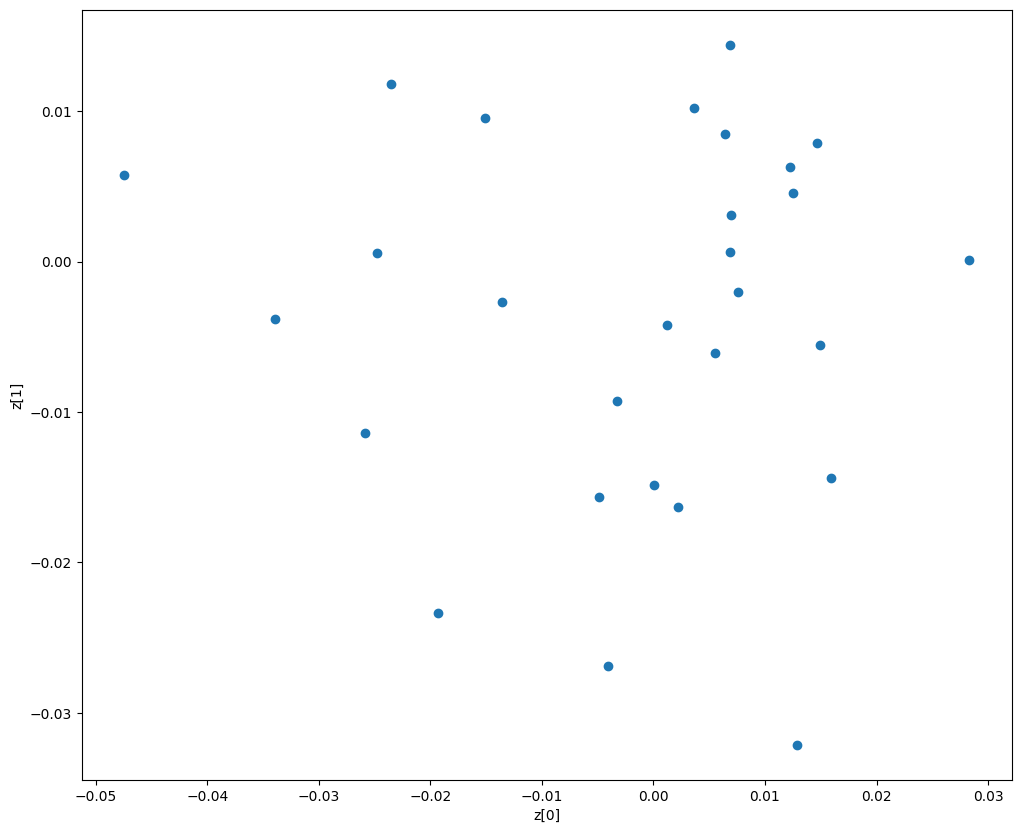

In [59]:
import matplotlib.pyplot as plt
with torch.no_grad():
    def plot_label_clusters(x):
        _,z_mean, _ = vae(x)
        plt.figure(figsize =(12, 10))
        print(z_mean.shape)
        sc = plt.scatter(z_mean[:, 0].numpy(), z_mean[:, 1].numpy())
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()
        
    plot_label_clusters(test_data_tensor)

In [72]:
plot_test_org=test_data_tensor.numpy()
plot_test_gen = decoded.numpy()

In [68]:
plot_test_gen.shape

(28, 50, 165)

In [69]:
import os
inference_path="output\inference\\"

frame: 0
frame: 1
frame: 2
frame: 3
frame: 4
frame: 5
frame: 6
frame: 7
frame: 8
frame: 9
frame: 10
frame: 11
frame: 12
frame: 13
frame: 14
frame: 15
frame: 16
frame: 17
frame: 18
frame: 19
frame: 20
frame: 21
frame: 22
frame: 23
frame: 24
frame: 25
frame: 26
frame: 27
frame: 28
frame: 29
frame: 30
frame: 31
frame: 32
frame: 33
frame: 34
frame: 35
frame: 36
frame: 37
frame: 38
frame: 39
frame: 40
frame: 41
frame: 42
frame: 43
frame: 44
frame: 45
frame: 46
frame: 47
frame: 48
frame: 49
frame: 0
frame: 1
frame: 2
frame: 3
frame: 4
frame: 5
frame: 6
frame: 7
frame: 8
frame: 9
frame: 10
frame: 11
frame: 12
frame: 13
frame: 14
frame: 15
frame: 16
frame: 17
frame: 18
frame: 19
frame: 20
frame: 21
frame: 22
frame: 23
frame: 24
frame: 25
frame: 26
frame: 27
frame: 28
frame: 29
frame: 30
frame: 31
frame: 32
frame: 33
frame: 34
frame: 35
frame: 36
frame: 37
frame: 38
frame: 39
frame: 40
frame: 41
frame: 42
frame: 43
frame: 44
frame: 45
frame: 46
frame: 47
frame: 48
frame: 49
frame: 0
frame: 1
fr

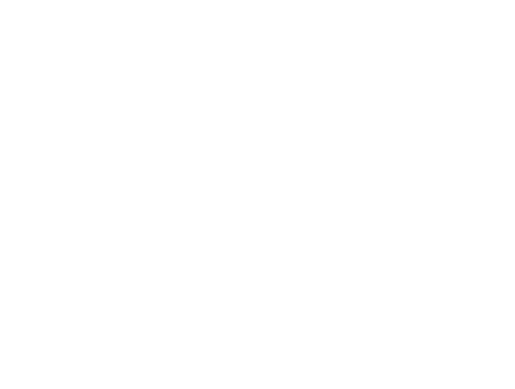

In [75]:
#n=plot_test_org.shape[0]
n=21
for i in range (15, 21):
    sample = i
    plot_test_org_sample=plot_test_org[sample]
    plot_test_org_reshaped=plot_test_org_sample.reshape(50, 55, 3).transpose(1, 0, 2)
    
    plot_test_gen_sample=plot_test_gen[sample]
    plot_test_gen_reshaped=plot_test_gen_sample.reshape(50, 55, 3).transpose(1, 0, 2)
    
    os.mkdir(inference_path+str(sample))
    
    visualize(50, plot_test_org_reshaped, 0, False, inference_path+str(sample)+"\original.avi") # visualization of original data
    visualize(50, plot_test_gen_reshaped, 0, False, inference_path+str(sample)+"\generated.avi") #visualization of test data
    